# Human Face Recognition using PCA

## Data Exploration

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.preprocessing import StandardScaler

figures_dir = "../figures"
os.makedirs(figures_dir, exist_ok=True)

### Step 1: Load the dataset

In [ ]:
print("Loading LFW dataset...")
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = lfw_dataset.images
X = lfw_dataset.data
n_samples, h, w = images.shape
target_names = lfw_dataset.target_names
n_classes = len(target_names)

print(f"Dataset loaded with {n_samples} samples.")
print(f"Image dimensions: {h}x{w}")
print(f"Number of classes: {n_classes}")
print("Classes:", target_names)

Loading LFW dataset...
Dataset loaded with 1288 samples.
Image dimensions: 50x37
Number of classes: 7
Classes: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


**Dataset Overview**

- **Dataset Name:** Labeled Faces in the Wild (LFW)
- **Number of Samples:** 1,288 images
- **Image Dimensions:** 50x37 pixels (height x width)
- **Number of Classes:** 7 distinct individuals
- **Class Labels:**
  - Ariel Sharon
  - Colin Powell
  - Donald Rumsfeld
  - George W. Bush
  - Gerhard Schroeder
  - Hugo Chavez
  - Tony Blair

This dataset contains facial images with a minimum of 70 images per individual. The smaller image dimensions (50x37) and the limited number of classes make it suitable for tasks such as facial recognition, classification, and feature extraction experiments.

### Visualizing a few images from the dataset

Displaying sample images...


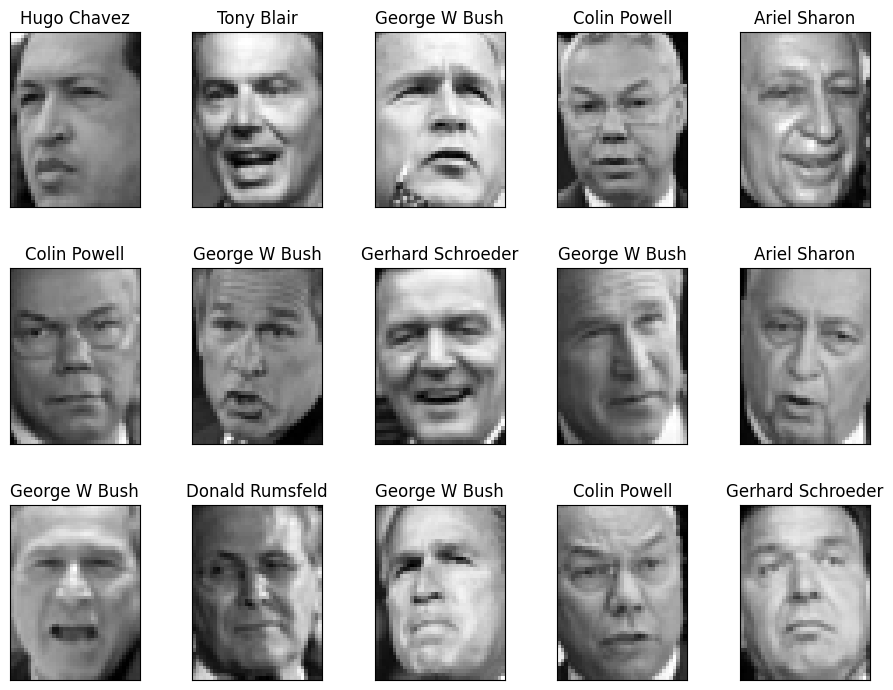

In [4]:
# Step 2: Visualize a few sample images
def plot_sample_images(images, target, target_names, h, w, n_row=3, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(target_names[target[i]], size=12)
        plt.xticks(())
        plt.yticks(())
    save_path = os.path.join(figures_dir, "sample_images.png")
    plt.savefig(save_path)
    plt.show()

print("Displaying sample images...")
plot_sample_images(images, lfw_dataset.target, target_names, h, w)

### Analyzing the dataset

Analyzing pixel intensity distribution...


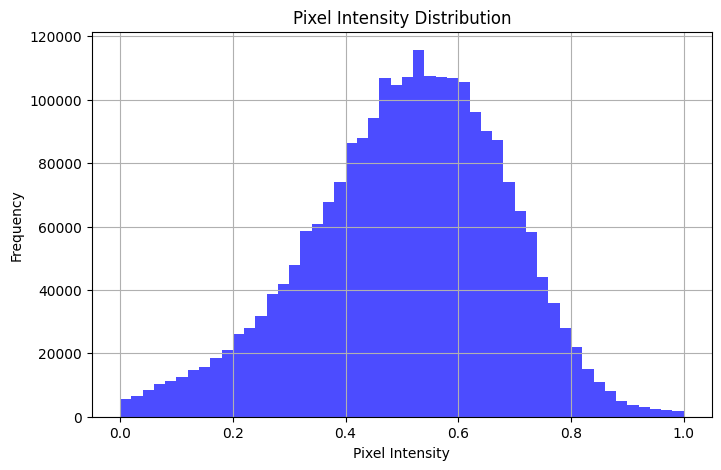

In [5]:
# Step 3: Analyze pixel intensity distribution
def plot_pixel_distribution(images):
    pixel_values = images.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    save_path = os.path.join(figures_dir, "pixel_intensity.png")
    plt.savefig(save_path)
    plt.show()

print("Analyzing pixel intensity distribution...")
plot_pixel_distribution(images)

Analyzing class distribution...


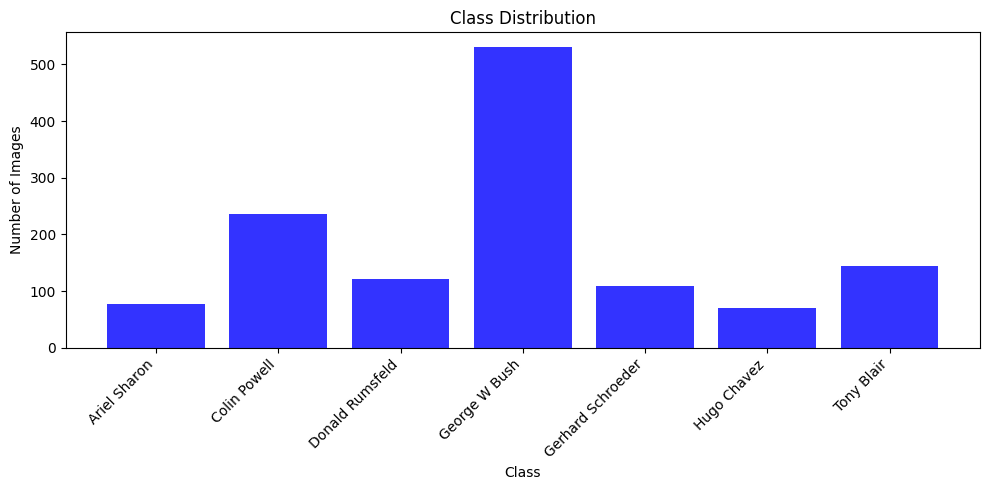

In [13]:
# Step 4: Class distribution
def plot_class_distribution(target, target_names):
    class_counts = np.bincount(target)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(target_names)), class_counts, color='blue', alpha=0.8)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(range(len(target_names)), target_names, rotation=45, ha="right")
    plt.tight_layout()
    save_path = os.path.join(figures_dir, "class_distribution.png")
    plt.savefig(save_path)
    plt.show()

print("Analyzing class distribution...")
plot_class_distribution(lfw_dataset.target, target_names)

In [14]:
# Step 5: Summary statistics for images
def compute_image_statistics(images):
    mean_image = np.mean(images, axis=0)
    std_image = np.std(images, axis=0)
    return mean_image, std_image

mean_image, std_image = compute_image_statistics(X)

Visualizing mean and standard deviation of images...


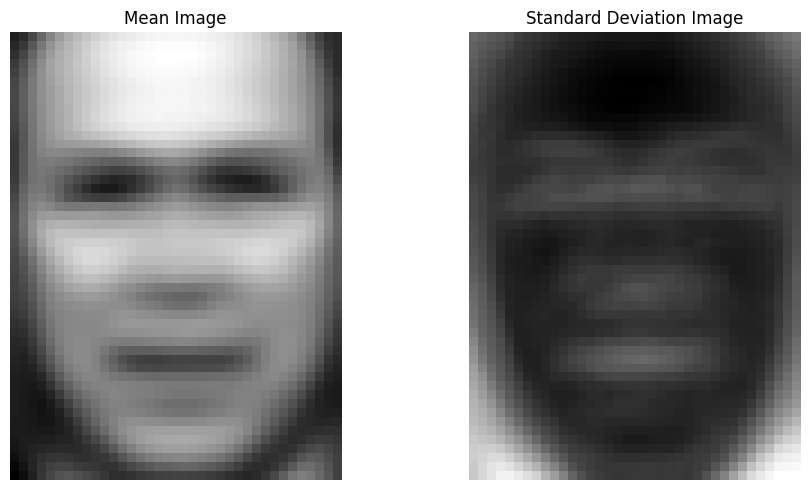

In [15]:
# Visualize mean and standard deviation images
def plot_image_statistics(mean_image, std_image, h, w):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mean_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title("Mean Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(std_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title("Standard Deviation Image")
    plt.axis("off")
    plt.tight_layout()
    save_path = os.path.join(figures_dir, "mean_sd.png")
    plt.savefig(save_path)
    plt.show()

print("Visualizing mean and standard deviation of images...")
plot_image_statistics(mean_image, std_image, h, w)

## PCA and Sparse PCA

Loading LFW dataset...
Dataset loaded with 1288 images of size 50x37.
Performing PCA...
Performing personalized SSPCA...
Performing Mini Batch SSPCA...
Visualizing Original Images...


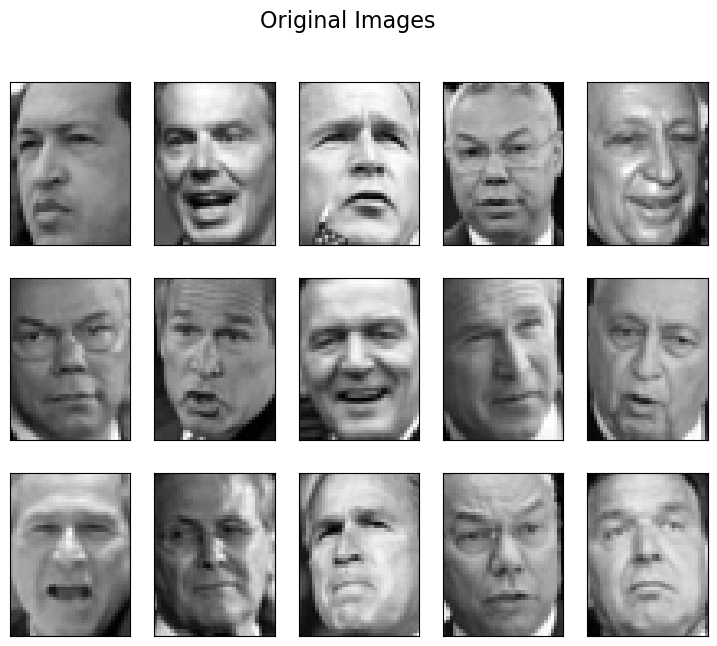

Visualizing PCA components...


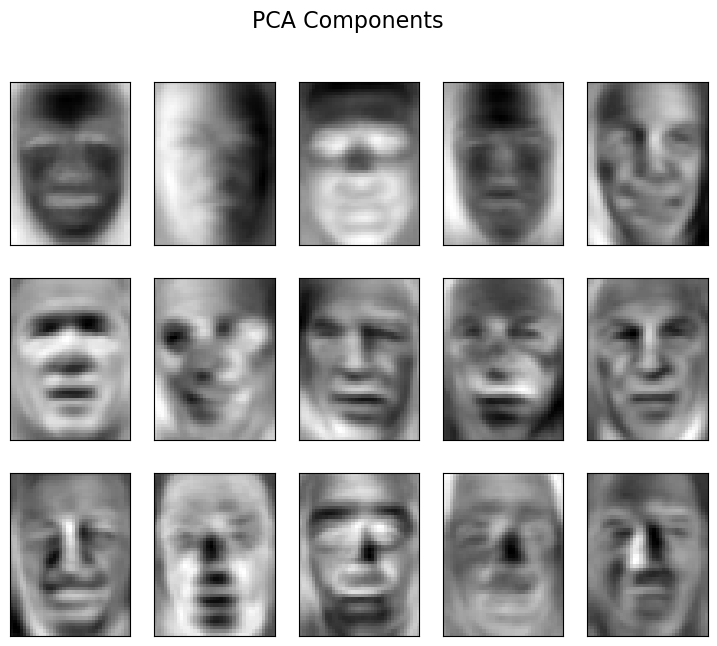

Visualizing personalized SSPCA components...


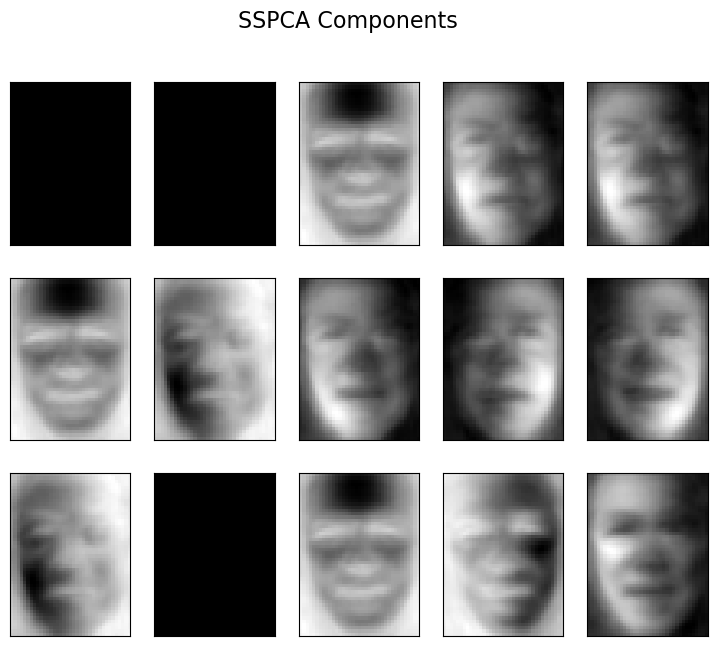

Visualizing Mini Batch SSPCA components...


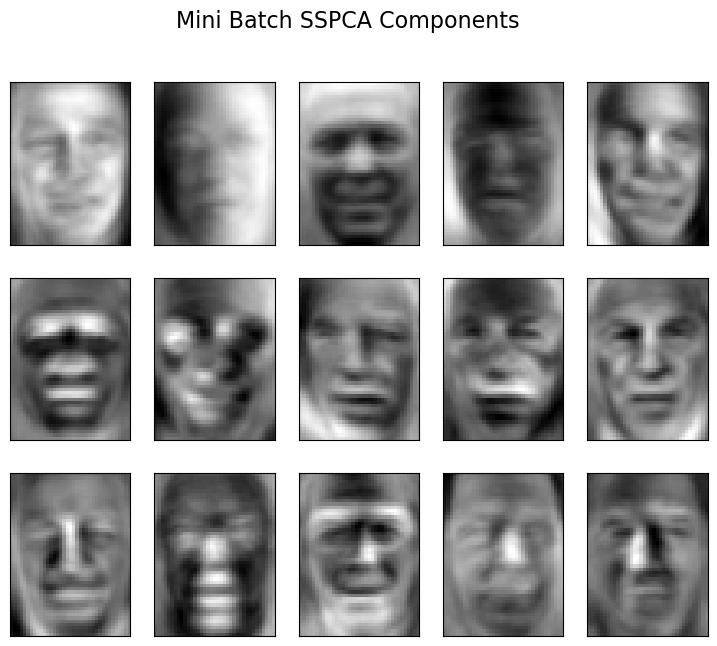

PCA Reconstruction Error: 0.2963
Personalized SSPCA Reconstruction Error: 17.9764
Mini Batch SSPCA Reconstruction Error: 0.3064


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: PCA Implementation
print("Performing PCA...")
n_components = 15
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
pca_components = pca.components_

# Step 3: Custom SSPCA Implementation
class SSPCA:
    def __init__(self, n_components, alpha=0.1, max_iter=50, group_size=5, tol=1e-6, verbose=False):
        self.n_components = n_components
        self.alpha = alpha
        self.max_iter = max_iter
        self.group_size = group_size
        self.tol = tol
        self.verbose = verbose

    def fit_transform(self, X):
        pca = PCA(n_components=self.n_components)
        Z = pca.fit_transform(X)  # PCA initialization
        components = pca.components_
        for iteration in range(self.max_iter):
            old_components = components.copy()
            components = self._apply_sparsity(components)
            Z = X @ components.T  # Update latent representation
            components = (Z.T @ X) / (np.linalg.norm(Z.T @ X, axis=1, keepdims=True) + 1e-8)

            # Check for convergence
            diff = np.linalg.norm(components - old_components)
            if self.verbose:
                print(f"Iteration {iteration + 1}, component diff = {diff}")
            if diff < self.tol:
                if self.verbose:
                    print("Converged early.")
                break
        self.components_ = components
        return Z

    def _apply_sparsity(self, components):
        for i in range(components.shape[0]):  # For each principal component
            for start in range(0, components.shape[1], self.group_size):
                end = min(start + self.group_size, components.shape[1])
                group = components[i, start:end]
                group_norm = np.linalg.norm(group)
                if group_norm <= self.alpha:
                    # Zero out the entire group
                    components[i, start:end] = 0.0
                else:
                    # Shrink the group
                    shrink_factor = 1 - self.alpha / group_norm
                    components[i, start:end] = group * shrink_factor
        return components

print("Performing personalized SSPCA...")
sspca = SSPCA(n_components=n_components, alpha=0.1)
X_sspca = sspca.fit_transform(X_scaled)
sspca_components = sspca.components_

print("Performing Mini Batch SSPCA...")
mb_sspca = MiniBatchSparsePCA(n_components=n_components, alpha=0.1, batch_size=100, max_iter=50)
X_mb_sspca = mb_sspca.fit_transform(X_scaled)
mb_sspca_components = mb_sspca.components_

# Step 4: Visualization of Components
def plot_gallery(title, images, n_col=5, n_row=3, image_shape=(h, w)):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images[:n_col * n_row]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.show()

print("Visualizing Original Images...")
plot_gallery("Original Images", X)

print("Visualizing PCA components...")
plot_gallery("PCA Components", pca_components, image_shape=(h, w))

print("Visualizing personalized SSPCA components...")
plot_gallery("SSPCA Components", sspca_components, image_shape=(h, w))

print("Visualizing Mini Batch SSPCA components...")
plot_gallery("Mini Batch SSPCA Components", mb_sspca_components, image_shape=(h, w))

# Step 5: Reconstruction Error Comparison
X_pca_reconstructed = pca.inverse_transform(X_pca)
X_sspca_reconstructed = X_scaled @ sspca_components.T @ sspca_components
X_mb_sspca_reconstructed = X_scaled @ mb_sspca_components.T @ mb_sspca_components

pca_reconstruction_error = np.mean((X_scaled - X_pca_reconstructed) ** 2)
sspca_reconstruction_error = np.mean((X_scaled - X_sspca_reconstructed) ** 2)
mb_sspca_reconstruction_error = np.mean((X_scaled - X_mb_sspca_reconstructed) ** 2)

print(f"PCA Reconstruction Error: {pca_reconstruction_error:.4f}")
print(f"Personalized SSPCA Reconstruction Error: {sspca_reconstruction_error:.4f}")
print(f"Mini Batch SSPCA Reconstruction Error: {mb_sspca_reconstruction_error:.4f}")